In [ ]:
# i need class to sampla datas from 1) frechet(1), with F(x) 
import matplotlib.pyplot as plt


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
from pystan import StanModel 
from numpy import polyval, place, extract, any, asarray, nan, inf, pi
from numpy import (where, arange, putmask, ravel, sum, shape,
                   log, sqrt, exp, arctanh, tan, sin, arcsin, arctan,
                   tanh, cos, cosh, sinh, log1p, expm1)

from scipy.stats import rv_continuous

class frechet_gen(rv_continuous):
#     def _argcheck(self, c):
#         c = asarray(c)
#         self.b = where(c < 0, 1.0/abs(c), inf)
#         return where(c == 0, 0, 1)

#     def _pdf(self, x, alpha1, alpha2, beta):
#         Px = 1 / beta / ss.beta(alpha1, alpha2) * pow(x/beta, asarray(alpha1-1.0)) * pow(1 + x/beta, asarray(- alpha1 - alpha2))
#         return Px

#     def _logpdf(self, x, alpha1, alpha2, beta):
#         return (alpha1 - 1) * np.log(x) - alpha1 * np.log(beta) - np.log(ss.beta(alpha1, alpha2)) - (alpha1 + alpha2) * np.log(1 + x/beta)

    def _cdf(self, x, beta):
        return exp(-pow(x, -1/beta))
#     def _ppf(self, q, c):
#         vals = 1.0/c * (pow(1-q, -c)-1)
#         return vals

#     def _munp(self, n, c):
#         k = arange(0, n+1)
#         val = (-1.0/c)**n * sum(comb(n, k)*(-1)**k / (1.0-c*k), axis=0)
#         return where(c*n < 1, val, inf)

#     def _entropy(self, c):
#         if (c > 0):
#             return 1+c
#         else:
#             self.b = -1.0 / c
#             return rv_continuous._entropy(self, c)
frechet = frechet_gen(a=0.0, name='frechet')

In [24]:
# here we are able to sample rv exactly as in publication
N, beta = 1000,  1/2 # run with n = 1000000
# beta = 1/2 because we want to have a finite mean
r = frechet.rvs(beta, size=N)
# np.mean(r)
# + histogram of data's

In [ ]:
# beta = 1/2 because we want to have a finite mean

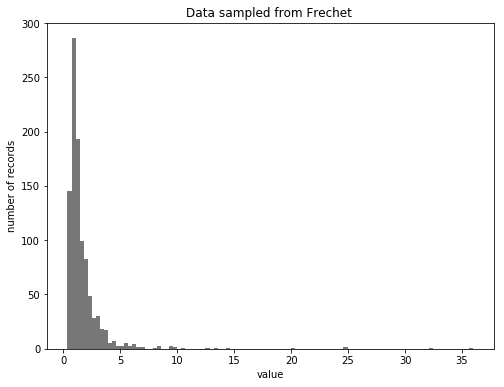

In [25]:
# histogram of data
fig, ax = plt.subplots(figsize=[8,6])

# set plot title
ax.set_title("Data sampled from Frechet ")

# set x-axis name
ax.set_xlabel("value")

# set y-axis name
ax.set_ylabel("number of records")

# create histogram within output
N, bins, patches = ax.hist(r, bins=100, color="#777777") #initial color of all bins

# Iterate through all histogram elements
# each element in this interation is one patch on the histogram, where:
# - bin_size - number of records in current bin
# - bin - value of current bin (x-axis)
# - patch - a rectangle, object of class matplotlib.patches.Patch
# more details on patch properties: [visit this link][1]

for bin_size, bin, patch in zip(N, bins, patches):
    if bin_size == 100:
        patch.set_facecolor("#FF000")
        patch.set_label("something")

plt.show()

In [26]:
from prettytable import PrettyTable
m = 3 # how much we round
t = PrettyTable(['pr.distr.', 'mean', 'sd', '2.5%', '25%', '50%', '75%', '97.5%'])
t.add_row(['Fréchet',
           "%.3f" % round(np.mean(r),m),
           "%.3f" % round(np.std(r),m),
           "%.3f" % round(np.percentile(r, 2.5),m), 
           "%.3f" % round(np.percentile(r, 25),m), 
           "%.3f" % round(np.percentile(r, 50),m), 
           "%.3f" % round(np.percentile(r, 75),m), 
           "%.3f" % round(np.percentile(r, 97.5),m)])
# t.add_row(['Bob', 19])
print(t)

+-----------+-------+-------+-------+-------+-------+-------+-------+
| pr.distr. |  mean |   sd  |  2.5% |  25%  |  50%  |  75%  | 97.5% |
+-----------+-------+-------+-------+-------+-------+-------+-------+
|  Fréchet  | 1.758 | 2.362 | 0.531 | 0.847 | 1.194 | 1.884 | 6.179 |
+-----------+-------+-------+-------+-------+-------+-------+-------+


In [ ]:
# sd >> mean wtf!

In [27]:
# we need a function to get a excesses
def k_greatest_values(a,k):
    """returns k greatest elements from the list and k-1 value starting from which we consider values to be extreme"""
    u = np.sort(a, axis=None)[-1-k]
    a = np.sort(a, axis=None)[-1-k+1:]
    a = asarray([a-u for x in a])
    return(a[1].tolist(), u) # u the starting value from which we consider others as excesses

In [28]:
k = 100 # number of excesses
frechet, u = k_greatest_values(r, k)
# frechet # so we recover  k = 100 excesses sampled from Frechet distribution

In [ ]:
import pystan
from pystan import StanModel 

In [ ]:
GPD = """
functions {
  real myGPD_lpdf(real y, real alpha, real beta) {
      //return -(1+1/c)*log(1+c*y2);
      return -(alpha + 1)*( log(1+y/beta) )+(log(alpha) - log(beta));
  }
  // above distribution is a special case of the distribution in the paper for alpha = beta = 1 / c
  // c = 1/beta
}
data { 
  int N;
  real y[N]; // points sampled from gpd in python with some(known) parameters, by mcmc we recover true values of those params
}
parameters { 
  //real c; 
  real alpha;
  real beta;
}
model {
  // Priors
  // no priors - we assume improper priors on params
  // c ~ uniform(0,1);
  alpha ~ gamma(2,2);
  beta ~ gamma(2,2);

// Likelihood
  for(n in 1:N) {
    target += myGPD_lpdf( y[n] | alpha, beta );
  }

}
generated quantities{}
"""

In [ ]:
#the same prior in gpd and fischer to compare

In [ ]:
data = dict(N = k,  y = frechet) 
fit = StanModel(model_code=GPD).sampling(data=data,iter=1000,warmup=200, chains=1) #we sample from the provided data ;
print(fit)

In [ ]:
beta = np.mean(list(fit.extract().values())[1].tolist())
alpha = np.mean(list(fit.extract().values())[0].tolist())
print("alpha = ", alpha, "\n beta = ", beta)
gamma = 1 / alpha 

In [ ]:
# table to compare with table before (beginning)
def quantile_GPD(N, k, p, beta, gamma, u):
    return( u + beta*( ( N * p / k )**( -gamma ) - 1 ) ) # p = 0.05


In [ ]:
quant_GPD = quantile_GPD(N, k, 0.05, beta, gamma, u)# p=0.05 check more values of quantiles 2.5%, 25 % ....

In [ ]:
quant_GPD

In [ ]:
beta_values = list(fit.extract().values())[1].tolist()
alpha_values = list(fit.extract().values())[0].tolist()

In [ ]:
# define window size, output and axes
fig, ax = plt.subplots(figsize=[8,6])

# set plot title
ax.set_title("Values of beta in GPD(alpha, beta) fitted to the excesses from Frechet ")

# set x-axis name
ax.set_xlabel("beta")

# set y-axis name
ax.set_ylabel("number of records")

# create histogram within output
N, bins, patches = ax.hist(beta_values, bins=50, color="#777777") #initial color of all bins

# Iterate through all histogram elements
# each element in this interation is one patch on the histogram, where:
# - bin_size - number of records in current bin
# - bin - value of current bin (x-axis)
# - patch - a rectangle, object of class matplotlib.patches.Patch
# more details on patch properties: [visit this link][1]

for bin_size, bin, patch in zip(N, bins, patches):
    if bin_size == 50:
        patch.set_facecolor("#777777")
        patch.set_label("something")

plt.show()
#plot with more values

In [ ]:
# define window size, output and axes
fig, ax = plt.subplots(figsize=[8,6])

# set plot title
ax.set_title("Values of alpha in GPD(alpha, beta) fitted to the excesses from Frechet ")

# set x-axis name
ax.set_xlabel("alpha")

# set y-axis name
ax.set_ylabel("number of records")

# create histogram within output
N, bins, patches = ax.hist(alpha_values, bins=50, color="#777777") #initial color of all bins

# Iterate through all histogram elements
# each element in this interation is one patch on the histogram, where:
# - bin_size - number of records in current bin
# - bin - value of current bin (x-axis)
# - patch - a rectangle, object of class matplotlib.patches.Patch
# more details on patch properties: [visit this link][1]

for bin_size, bin, patch in zip(N, bins, patches):
    if bin_size == 50:
        patch.set_facecolor("#777777")
        patch.set_label("something")

plt.show()

In [ ]:
Fisher = """
functions { 
 real myFisher_lpdf(real y, real alpha1, real alpha2, real beta) {
      return -lbeta(alpha1,alpha2)-log(beta)+(alpha1-1)*log(y/beta)-(alpha1+alpha2)*log(1+y/beta);
  }
  
// to recover more general distribution of Fisher parametrized by three parameters we need to multiply the above distribution 
// by: df1**df1/2
// we have alpha1,2 = df1,2/2, beta = df2/df1
}

data { 
  int N;
  real y[N]; // points sampled from fisher in python with some(known) parameters, by mcmc we recover true values of those params
}
parameters { 
  //parameters of the Fisher
  //real df1;
  //real df2;
  real<lower=0> alpha1;
  real<lower=0> alpha2;
  real<lower=0> beta;
  
}
model {
  // when we deliberately do not specify priors then Stan works with improper priors
  //alpha1 ~ gamma(2,2);
  //alpha2 ~ gamma(2,2);
  //beta ~ gamma(2,2);
   // Likelihood
  for(n in 1:N) {
    target += myFisher_lpdf( y[n] |alpha1, alpha2, beta);
  }
}

generated quantities{}
"""

In [ ]:
data = dict(N = k,  y = frechet) 
fit = StanModel(model_code=Fisher).sampling(data=data,iter=1000,warmup=200, chains=1) #we sample from the provided data ;
print(fit)

In [ ]:
beta = np.mean(list(fit.extract().values())[2].tolist())
alpha2 = np.mean(list(fit.extract().values())[1].tolist())
alpha1 = np.mean(list(fit.extract().values())[0].tolist())
print(" alpha1 = ", alpha1, "\n alpha2 = ", alpha2, "\n beta = ", beta)
# gamma = 1 / alpha 

In [ ]:
#we need Fisher quantiles
def quantile_Fischer(N, k, p, beta, gamma, u):
    return( u + beta*( ( N * p / k )**( -gamma ) - 1 ) ) # p = 0.05


In [ ]:
alpha1_values = list(fit.extract().values())[0].tolist()
alpha2_values = list(fit.extract().values())[1].tolist()
beta_values = list(fit.extract().values())[2].tolist()
 

In [ ]:
# define window size, output and axes
fig, ax = plt.subplots(figsize=[8,6])

# set plot title
ax.set_title("Values of beta in Fisher(alpha1, alpha2, beta) fitted to the excesses from Frechet ")

# set x-axis name
ax.set_xlabel("beta")

# set y-axis name
ax.set_ylabel("number of records")

# create histogram within output
N, bins, patches = ax.hist(beta_values, bins=25, color="#777777") #initial color of all bins

# Iterate through all histogram elements
# each element in this interation is one patch on the histogram, where:
# - bin_size - number of records in current bin
# - bin - value of current bin (x-axis)
# - patch - a rectangle, object of class matplotlib.patches.Patch
# more details on patch properties: [visit this link][1]

for bin_size, bin, patch in zip(N, bins, patches):
    if bin_size == 25:
        patch.set_facecolor("#FF000")
        patch.set_label("something")

plt.show()

In [ ]:
# define window size, output and axes
fig, ax = plt.subplots(figsize=[8,6])

# set plot title
ax.set_title("Values of alpha1 in Fisher(alpha1, alpha2, beta) fitted to the excesses from Frechet ")

# set x-axis name
ax.set_xlabel("alpha1")

# set y-axis name
ax.set_ylabel("number of records")

# create histogram within output
N, bins, patches = ax.hist(alpha1_values, bins=25, color="#777777") #initial color of all bins

# Iterate through all histogram elements
# each element in this interation is one patch on the histogram, where:
# - bin_size - number of records in current bin
# - bin - value of current bin (x-axis)
# - patch - a rectangle, object of class matplotlib.patches.Patch
# more details on patch properties: [visit this link][1]

for bin_size, bin, patch in zip(N, bins, patches):
    if bin_size == 25:
        patch.set_facecolor("#FF000")
        patch.set_label("something")

plt.show()

In [ ]:
# define window size, output and axes
fig, ax = plt.subplots(figsize=[8,6])

# set plot title
ax.set_title("Values of alpha2 in Fisher(alpha1, alpha2, beta) fitted to the excesses from Frechet ")

# set x-axis name
ax.set_xlabel("alpha2")

# set y-axis name
ax.set_ylabel("number of records")

# create histogram within output
N, bins, patches = ax.hist(alpha2_values, bins=25, color="#777777") #initial color of all bins

# Iterate through all histogram elements
# each element in this interation is one patch on the histogram, where:
# - bin_size - number of records in current bin
# - bin - value of current bin (x-axis)
# - patch - a rectangle, object of class matplotlib.patches.Patch
# more details on patch properties: [visit this link][1]

for bin_size, bin, patch in zip(N, bins, patches):
    if bin_size == 25:
        patch.set_facecolor("#777777")
        patch.set_label("something")

plt.show()

In [ ]:
print("Below tries to average over multiple sets of excesses, for some reason it doesn't work")

In [ ]:
def quantile_Fischer(N, k, p, beta, gamma, u):
    return( u + beta*( ( N * p / k )**( -gamma ) - 1 ) ) # p = 0.05


In [ ]:
t = frechet.rvs(beta, size=N)

In [ ]:
t

In [ ]:
#ok, now we generate multiple datasets to be able to average over all the results
n = 20 # number of datasets we investigate

for i in range(n):
    t = frechet.rvs(beta, size=N)
    r = np.column_stack((r, t)) # 20 replications of datas from frechet distribution in columns


In [ ]:
t = frechet.rvs(beta, size=N)# why here it doesn't work while before it worked well?

In [ ]:
import numpy as np
a = np.array([1,2,3,4,5])
p = np.percentile(a, 50) # return 50th percentile, e.g median.
print p
3.0